<a href="https://colab.research.google.com/github/step-cheng/cs496_gradienttheory/blob/main/CS496FinalExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS496 Final Project Experiments - Shampoo**

All code is below but brief synopsis.

Hyperparameters for Experiment 1 & Experiment 3 were grid searched. (The results from one grid search one are in the cell output at the bottom, but it was actually run many times with many different combinations, and for more than 3 epochs) Hyperparameters for Experiment 2 were just the best of ~10 tried, because we do not have enough GPU resources to train the model a bunch of times, and the model was way more sensitive (it failed to converge for many hyperparameter combinations, unlike Resnet which was fairly insensitive).

The most notable change from the intermediate report is that we implement the Diagonal Shampoo algorithm (described in Appendix A of the original paper) for high dimensional preconditioning matrices. The base Shampoo algorithm runs fine on Resnet-34 but the memory requirements explode beyond any reasonable value for larger models like DistillBERT.

Experiment 1 (Resnet-34 CIFAR-10 training):
  Shampoo underperforms after about ~3 epochs, and test accuracy stops improving. This was true regardless of hyperparameter picked.

Experiment 2 (DistilBERT SST-2 Finetuning):
  Shampoo underperforms the other optimizers, but takes longer, and requires significantly more hyperparameter tuning.

Experiment 3 (1/2 vs 1/4 Exponent):
  1/4 exponent appears to perform better than 1/2

# **Setup**

In [ ]:
!pip install torch-optimizer
!pip install transformers datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as optim_ext
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import copy
import gc
import math
import time
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Optimizer

from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/liampatterson/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Shampoo Implementation

In [ ]:
class Shampoo(Optimizer):
    def __init__(
        self,
        params,
        gamma=0.1,
        alpha=0.8,
        epsilon=1e-1,
        f=50,
        exponent=0.5,
        diag_threshold=1200
    ):
        defaults = dict(
            gamma=gamma,
            alpha=alpha,
            epsilon=epsilon,
            f=f,
            exponent=exponent,
            diag_threshold=diag_threshold
        )
        super().__init__(params, defaults)

    def _init_preconditioners(self, state, grad_f_W_t, epsilon, diag_threshold):
        if "H_t" not in state:
            k = grad_f_W_t.ndim
            state["H_t"] = {}
            state["H_t_inv"] = {}
            state["dim_sizes"] = list(grad_f_W_t.shape)

            for i in range(k):
                d_i = grad_f_W_t.shape[i]
                if d_i > diag_threshold:
                    H_i_init = epsilon * torch.ones(
                        d_i, device=grad_f_W_t.device, dtype=grad_f_W_t.dtype
                    )
                else:
                    H_i_init = epsilon * torch.eye(
                        d_i, device=grad_f_W_t.device, dtype=grad_f_W_t.dtype
                    )
                state["H_t"][i] = H_i_init
                state["H_t_inv"][i] = None

    def _update_and_precondition(self, G_t, state, t, f, exponent):
        G_t_tilde = G_t
        k = G_t.ndim

        for i in range(k):
            G_t_tilde = G_t_tilde.transpose(0, i).contiguous()
            d_i = state["dim_sizes"][i]
            original_shape = G_t_tilde.size()
            G_t_i = G_t_tilde.view(d_i, -1)

            H_i = state["H_t"][i]
            if H_i.dim() == 1:
                diag_update = (G_t_i ** 2).sum(dim=1)
                H_i.add_(diag_update)

                if t % f == 0:
                    H_i_inv = H_i.clamp_min(1e-12).pow(-exponent)
                    state["H_t_inv"][i] = H_i_inv

                H_inv_i = state["H_t_inv"][i]
                if H_inv_i is not None:
                    G_t_i = H_inv_i.unsqueeze(1) * G_t_i
                G_t_tilde = G_t_i.view(original_shape).transpose(0, i)

            else:
                H_i.add_(G_t_i @ G_t_i.t())

                if t % f == 0:
                    eigvals, eigvecs = torch.linalg.eigh(H_i)
                    eigvals = eigvals.clamp_min(1e-12).pow(-exponent)
                    H_i_inv = eigvecs @ torch.diag(eigvals) @ eigvecs.transpose(-1, -2)
                    state["H_t_inv"][i] = H_i_inv

                H_inv_i = state["H_t_inv"][i]
                if H_inv_i is not None:
                    G_t_i = H_inv_i @ G_t_i
                G_t_tilde = G_t_i.view(original_shape).transpose(0, i)

        return G_t_tilde

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            gamma = group["gamma"]
            alpha = group["alpha"]
            epsilon = group["epsilon"]
            f = group["f"]
            exponent = group["exponent"]
            diag_threshold = group["diag_threshold"]

            if "t" not in group:
                group["t"] = 0
            group["t"] += 1
            t = group["t"]

            for W_t in group["params"]:
                if W_t.grad is None:
                    continue

                grad_f_W_t = W_t.grad.data
                state = self.state[W_t]

                if "G_t" not in state:
                    state["G_t"] = torch.zeros_like(grad_f_W_t)
                G_t = state["G_t"]
                G_t.mul_(alpha).add_(grad_f_W_t, alpha=(1 - alpha))

                self._init_preconditioners(state, grad_f_W_t, epsilon, diag_threshold)

                G_t_tilde = self._update_and_precondition(G_t, state, t, f, exponent)

                W_t.data.add_(G_t_tilde, alpha=-gamma)


Helpers

In [ ]:
def _create_optimizer(optimizer_name, parameters,
                      lr=0.2, momentum=0.8, eps=1e-1,
                      update_freq=5, weight_decay=0.0, alpha=None):
    if alpha is None:
        alpha = momentum

    if optimizer_name == 'SGD':
        return optim.SGD(parameters, lr=lr, momentum=momentum)
    elif optimizer_name == 'Adam':
        return optim.Adam(parameters, lr=lr, eps=eps)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(parameters, lr=lr, eps=eps)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(parameters, lr=lr)
    elif optimizer_name == 'Shampoo':
        return Shampoo(parameters,
                       gamma=lr,
                       alpha=momentum,
                       epsilon=eps,
                       f=update_freq)
    elif optimizer_name == 'ReferenceShampoo':
        return optim_ext.Shampoo(parameters,
                                 lr=lr,
                                 momentum=momentum,
                                 epsilon=eps,
                                 update_freq=update_freq,
                                 weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")
def _create_optimizer(optimizer_name, parameters,
                      lr=0.2, momentum=0.8, eps=1e-1,
                      update_freq=5, weight_decay=0.0, alpha=None):
    if alpha is None:
        alpha = momentum

    if optimizer_name == 'SGD':
        return optim.SGD(parameters, lr=0.001, momentum=.9)
    elif optimizer_name == 'Adam':
        return optim.Adam(parameters, lr=.001, weight_decay=.001)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(parameters, lr=.001, weight_decay=.001)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(parameters, lr=.001, weight_decay=.001)
    elif optimizer_name == 'Shampoo':
        return Shampoo(parameters,
                       gamma=.001,
                       alpha=.8,
                       epsilon=1e-1,
                       f=50)
    elif optimizer_name == 'ReferenceShampoo':
        return optim_ext.Shampoo(parameters,
                                 lr=lr,
                                 momentum=momentum,
                                 epsilon=eps,
                                 update_freq=update_freq,
                                 weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")

CIFAR-10 / RESNET

In [ ]:
train_loader = None
test_loader = None
def _train_loop_cifar(model, optimizer, train_loader, test_loader, device,
                      num_epochs, lr, momentum, eps, update_freq, weight_decay,
                      optimizer_name):
    criterion = nn.CrossEntropyLoss()

    train_loss_per_epoch = []
    test_acc_per_epoch = []
    mem_usage_per_epoch = []
    avg_step_time_per_epoch = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        if device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats(device)

        start_epoch_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        end_epoch_time = time.time()
        epoch_duration = end_epoch_time - start_epoch_time
        average_step_time = epoch_duration / len(train_loader)
        avg_step_time_per_epoch.append(average_step_time)

        avg_loss = running_loss / len(train_loader)
        train_loss_per_epoch.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total
        test_acc_per_epoch.append(accuracy)

        if device.type == 'cuda':
            peak_mem = torch.cuda.max_memory_allocated(device) / (1024**2)
        else:
            peak_mem = 0.0
        mem_usage_per_epoch.append(peak_mem)

        print(f"[{optimizer_name}] Epoch {epoch}/{num_epochs} | "
              f" Test Acc: {accuracy:.2f}% | "
              f"PeakMem: {peak_mem:.1f} MB | Avg Step Time: {average_step_time:.4f}s")

    return train_loss_per_epoch, test_acc_per_epoch, mem_usage_per_epoch, avg_step_time_per_epoch

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False, num_workers=6)


Files already downloaded and verified
Files already downloaded and verified


# **RESNET-34 Optimizer Comparisons**

In [ ]:
def run_cifar_experiment():
  base_model = torchvision.models.resnet34(weights=None, num_classes=10)

  optimizers_to_compare = ["Shampoo", "SGD", "Adam", "AdamW", "Adagrad"]
  num_epochs = 30

  results = {}

  for opt_name in optimizers_to_compare:
      gc.collect()
      torch.cuda.empty_cache()
      print(f"\n===== Training with {opt_name} =====")

      model_copy = copy.deepcopy(base_model).to(device)

      optimizer = _create_optimizer_cifar_10(
          opt_name, model_copy.parameters(),
          lr=0.2, momentum=0.4, eps=1e-1,
          update_freq=3, weight_decay=0.0
      )

      (train_loss, test_acc, mem_usage, step_time) = _train_loop_cifar(
          model_copy, optimizer,
          train_loader, test_loader, device,
          num_epochs=num_epochs,
          lr=0.2, momentum=0.4, eps=1e-1,
          update_freq=5, weight_decay=0.0,
          optimizer_name=opt_name
      )

      results[opt_name] = {
          "loss": train_loss,
          "acc": test_acc,
          "mem": mem_usage,
          "time": step_time
      }

  epochs_range = range(1, num_epochs + 1)
  plt.figure(figsize=(20, 4))

  plt.subplot(1, 4, 1)
  for opt_name in optimizers_to_compare:
      plt.plot(epochs_range, results[opt_name]["loss"], label=opt_name)
  plt.title("Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 4, 2)
  for opt_name in optimizers_to_compare:
      plt.plot(epochs_range, results[opt_name]["acc"], label=opt_name)
  plt.title("Test Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend()

  plt.subplot(1, 4, 3)
  for opt_name in optimizers_to_compare:
      plt.plot(epochs_range, results[opt_name]["mem"], label=opt_name)
  plt.title("Peak GPU Memory Usage")
  plt.xlabel("Epoch")
  plt.ylabel("MB")
  plt.legend()

  plt.subplot(1, 4, 4)
  for opt_name in optimizers_to_compare:
      plt.plot(epochs_range, results[opt_name]["time"], label=opt_name)
  plt.title("Avg Step Time Per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Time (s)")
  plt.legend()

  plt.tight_layout()
  plt.show()


===== Training with Shampoo =====
[Shampoo] Epoch 1/30 |  Test Acc: 47.82% | PeakMem: 1132.0 MB | Avg Step Time: 0.0397s
[Shampoo] Epoch 2/30 |  Test Acc: 50.16% | PeakMem: 1132.8 MB | Avg Step Time: 0.0456s
[Shampoo] Epoch 3/30 |  Test Acc: 51.03% | PeakMem: 1132.5 MB | Avg Step Time: 0.0455s
[Shampoo] Epoch 4/30 |  Test Acc: 51.64% | PeakMem: 1132.8 MB | Avg Step Time: 0.0451s
[Shampoo] Epoch 5/30 |  Test Acc: 51.28% | PeakMem: 1132.5 MB | Avg Step Time: 0.0447s
[Shampoo] Epoch 6/30 |  Test Acc: 50.71% | PeakMem: 1132.8 MB | Avg Step Time: 0.0450s
[Shampoo] Epoch 7/30 |  Test Acc: 51.09% | PeakMem: 1132.5 MB | Avg Step Time: 0.0458s
[Shampoo] Epoch 8/30 |  Test Acc: 50.89% | PeakMem: 1132.8 MB | Avg Step Time: 0.0459s
[Shampoo] Epoch 9/30 |  Test Acc: 50.91% | PeakMem: 1132.5 MB | Avg Step Time: 0.0441s
[Shampoo] Epoch 10/30 |  Test Acc: 50.58% | PeakMem: 1132.8 MB | Avg Step Time: 0.0436s
[Shampoo] Epoch 11/30 |  Test Acc: 50.55% | PeakMem: 1132.5 MB | Avg Step Time: 0.0458s
[Shamp

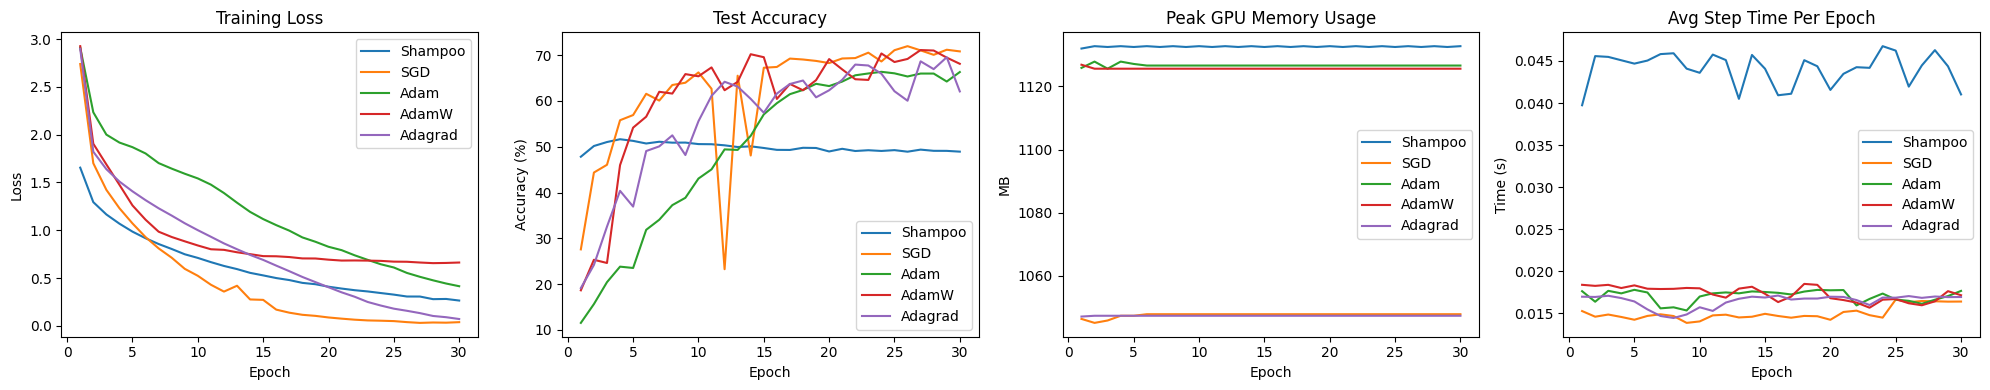

In [ ]:
run_cifar_experiment()

# ***DistilBERT SST-2***

Setup

In [ ]:
data = load_dataset("glue", "sst2")
train_data = data["train"]
val_data   = data["validation"]

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize_batch, batched=True)
val_data   = val_data.map(tokenize_batch,   batched=True)

train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format("torch",   columns=["input_ids", "attention_mask", "label"])

train_loader_nlp = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
val_loader_nlp   = torch.utils.data.DataLoader(val_data,   batch_size=256, shuffle=False)

base_model_nlp = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_and_eval_bert(optimizer_name, base_model, train_loader, val_loader, device, num_epochs=3):
    model = copy.deepcopy(base_model).to(device)
    if optimizer_name == "SGD":
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=.0001)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.0001)
    elif optimizer_name == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=1e-4, weight_decay=0.0001)
    elif optimizer_name == 'Shampoo':
        optimizer = Shampoo(model.parameters(),
              gamma=1e-4,
              alpha=0.9,
              epsilon=1e-4,
              f=100,
              exponent=0.5,
              diag_threshold=1200)
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")

    criterion = nn.CrossEntropyLoss()

    train_loss_per_epoch = []
    val_acc_per_epoch = []
    mem_usage_per_epoch = []
    avg_step_time_per_epoch = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats(device)

        start_epoch_time = time.time()
        print_interval = 100

        for batch_idx, batch in enumerate(train_loader, start=1):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % print_interval == 0:
                current_loss = running_loss / batch_idx
                print(f"[{optimizer_name}] Epoch {epoch}/{num_epochs} - "
                      f"Batch {batch_idx}/{len(train_loader)} - Avg Loss: {current_loss:.4f}")

        epoch_duration = time.time() - start_epoch_time
        average_step_time = epoch_duration / len(train_loader)
        avg_step_time_per_epoch.append(average_step_time)

        avg_loss = running_loss / len(train_loader)
        train_loss_per_epoch.append(avg_loss)

        model.eval()
        correct = 0
        total   = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels         = batch["label"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits  = outputs.logits
                _, predicted = torch.max(logits, dim=1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total
        val_acc_per_epoch.append(accuracy)

        if device.type == "cuda":
            peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        else:
            peak_mem = 0.0
        mem_usage_per_epoch.append(peak_mem)

        print(f"[{optimizer_name}] Epoch {epoch}/{num_epochs} | "
              f"Loss: {avg_loss:.4f} | Val Acc: {accuracy:.2f}% | "
              f"PeakMem: {peak_mem:.1f} MB | StepTime: {average_step_time:.4f}s")

    return train_loss_per_epoch, val_acc_per_epoch, mem_usage_per_epoch, avg_step_time_per_epoch

In [ ]:
def run_bert_experiment():
    optimizers_to_compare_nlp = ["Shampoo", "SGD", "Adam", "AdamW", "Adagrad"]
    num_epochs_nlp = 3
    results_nlp = {}

    for opt_name in optimizers_to_compare_nlp:
        gc.collect()
        torch.cuda.empty_cache()
        print(f"\n===== Training DistilBERT with {opt_name} =====")

        train_loss, val_acc, mem_usage, step_time = train_and_eval_bert(
            opt_name,
            base_model_nlp,
            train_loader_nlp,
            val_loader_nlp,
            device,
            num_epochs=num_epochs_nlp
        )

        results_nlp[opt_name] = {
            "loss": train_loss,
            "acc": val_acc,
            "mem": mem_usage,
            "time": step_time
        }

    epochs_range_nlp = range(1, num_epochs_nlp + 1)
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    for opt_name in optimizers_to_compare_nlp:
        plt.plot(epochs_range_nlp, results_nlp[opt_name]["loss"], label=opt_name)
    plt.title("Training Loss (NLP)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 4, 2)
    for opt_name in optimizers_to_compare_nlp:
        plt.plot(epochs_range_nlp, results_nlp[opt_name]["acc"], label=opt_name)
    plt.title("Validation Accuracy (NLP)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.subplot(1, 4, 3)
    for opt_name in optimizers_to_compare_nlp:
        plt.plot(epochs_range_nlp, results_nlp[opt_name]["mem"], label=opt_name)
    plt.title("Peak GPU Memory Usage (NLP)")
    plt.xlabel("Epoch")
    plt.ylabel("MB")
    plt.legend()

    plt.subplot(1, 4, 4)
    for opt_name in optimizers_to_compare_nlp:
        plt.plot(epochs_range_nlp, results_nlp[opt_name]["time"], label=opt_name)
    plt.title("Avg Step Time Per Epoch (NLP)")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.legend()

    plt.tight_layout()
    plt.show()



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/3 - Batch 100/264 - Avg Loss: 0.6962
[Shampoo] Epoch 1/3 - Batch 200/264 - Avg Loss: 0.6215
[Shampoo] Epoch 1/3 | Loss: 0.5405 | Val Acc: 88.42% | PeakMem: 11635.4 MB | StepTime: 0.6149s
[Shampoo] Epoch 2/3 - Batch 100/264 - Avg Loss: 0.2618
[Shampoo] Epoch 2/3 - Batch 200/264 - Avg Loss: 0.2615
[Shampoo] Epoch 2/3 | Loss: 0.2596 | Val Acc: 88.76% | PeakMem: 11635.9 MB | StepTime: 0.6167s
[Shampoo] Epoch 3/3 - Batch 100/264 - Avg Loss: 0.2622
[Shampoo] Epoch 3/3 - Batch 200/264 - Avg Loss: 0.2584
[Shampoo] Epoch 3/3 | Loss: 0.2572 | Val Acc: 88.42% | PeakMem: 11635.9 MB | StepTime: 0.5221s

===== Training DistilBERT with SGD =====
[SGD] Epoch 1/3 - Batch 100/264 - Avg Loss: 0.4280
[SGD] Epoch 1/3 - Batch 200/264 - Avg Loss: 0.3337
[SGD] Epoch 1/3 | Loss: 0.3056 | Val Acc: 89.91% | PeakMem: 11082.7 MB | StepTime: 0.4950s
[SGD] Epoch 2/3 - Batch 100/264 - Avg Loss: 0.1646
[SGD] Epoch 2/3 - Batch 200/264 - Avg Loss: 0.1635
[S

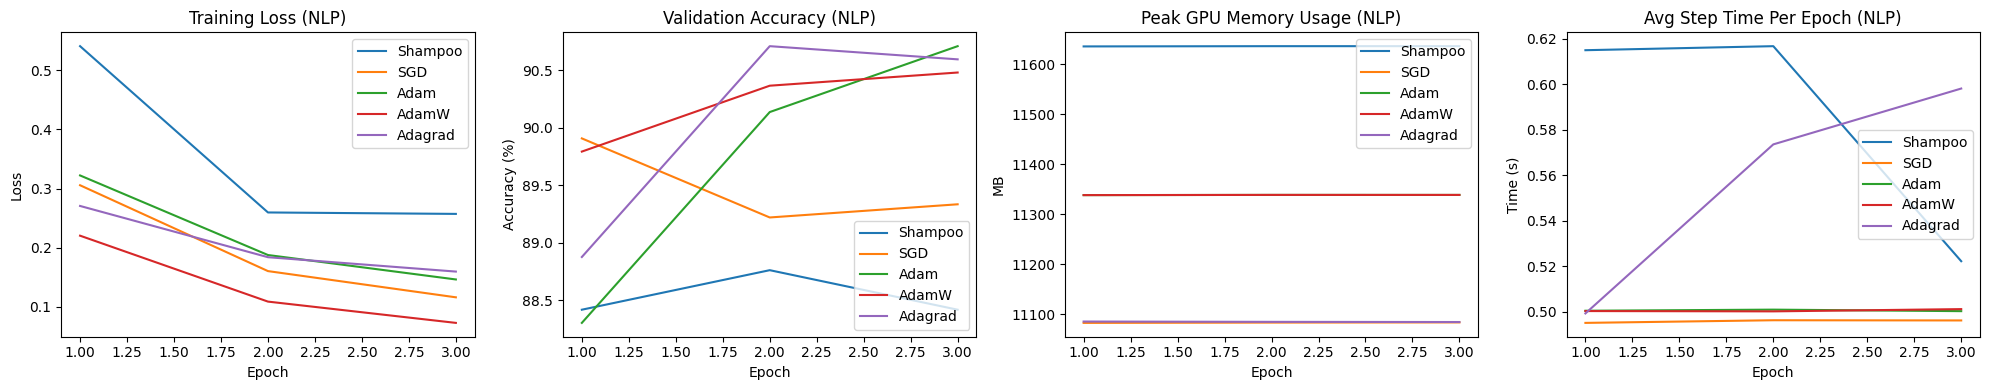

In [ ]:
run_bert_experiment()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# **1/2 vs 1/4 Exponent**

In [ ]:
def train_with_optimizer(opt_class, opt_kwargs, train_loader, test_loader, device, num_epochs=10):
    torch.manual_seed(42)
    model = torchvision.models.resnet34(weights=None, num_classes=10).to(device)

    optimizer = opt_class(model.parameters(), **opt_kwargs)
    criterion = nn.CrossEntropyLoss()

    epoch_metrics = {"loss": [], "time": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats(device)

        start_epoch = time.time()
        print_interval = 10

        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        epoch_time = time.time() - start_epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_metrics["loss"].append(epoch_loss)
        epoch_metrics["time"].append(epoch_time)
        print(f"Epoch {epoch} completed in {epoch_time:.2f}s - Loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, epoch_metrics

In [ ]:
def run_preconditioner_exp_test():
  print("\nTraining with Shampoo optimizer (preconditioner exponent = 1/4)...")
  acc_1_4, metrics_1_4 = train_with_optimizer(
    Shampoo,
    {'exponent': 0.25},
    train_loader, test_loader, device, num_epochs=10
  )
  print(f"Final Test Accuracy with Shampoo (1/4 exponent): {acc_1_4:.2f}%")

  print("\nTraining with Shampoo optimizer (preconditioner exponent = 1/2)...")
  acc_1_2, metrics_1_2 = train_with_optimizer(
    Shampoo,
    {'exponent': 0.5},
    train_loader, test_loader, device, num_epochs=10
  )
  print(f"Final Test Accuracy with Shampoo (1/2 exponent): {acc_1_2:.2f}%")

In [ ]:
run_preconditioner_exp_test()


Training with Shampoo optimizer (preconditioner exponent = 1/4)...
Epoch 1 completed in 7.65s - Loss: 1.6743
Epoch 2 completed in 8.47s - Loss: 1.2324
Epoch 3 completed in 8.21s - Loss: 1.0029
Epoch 4 completed in 8.86s - Loss: 0.8037
Epoch 5 completed in 8.88s - Loss: 0.6011
Epoch 6 completed in 9.03s - Loss: 0.4097
Epoch 7 completed in 8.85s - Loss: 0.2554
Epoch 8 completed in 8.30s - Loss: 0.1732
Epoch 9 completed in 8.80s - Loss: 0.1090
Epoch 10 completed in 8.47s - Loss: 0.0729
Test Accuracy: 59.97%
Final Test Accuracy with Shampoo (1/4 exponent): 59.97%

Training with Shampoo optimizer (preconditioner exponent = 1/2)...
Epoch 1 completed in 7.01s - Loss: 1.6886
Epoch 2 completed in 8.51s - Loss: 1.2578
Epoch 3 completed in 8.96s - Loss: 1.0982
Epoch 4 completed in 8.88s - Loss: 0.9657
Epoch 5 completed in 8.83s - Loss: 0.8493
Epoch 6 completed in 8.93s - Loss: 0.7456
Epoch 7 completed in 8.79s - Loss: 0.6457
Epoch 8 completed in 9.08s - Loss: 0.5651
Epoch 9 completed in 9.02s - 

# **Grid Search Utils**

In [ ]:
def train_and_eval_grid(
    optimizer_name,
    model,
    train_loader,
    test_loader,
    device,
    num_epochs=5,
    learning_rate=0.0002,
    momentum=0.4,
    epsilon=1e-4,
    update_freq=5,
    weight_decay=0.0
):
    model_copy = copy.deepcopy(model).to(device)

    optimizer = _create_optimizer(
        optimizer_name, model_copy.parameters(),
        lr=learning_rate, momentum=momentum, eps=epsilon,
        update_freq=update_freq, weight_decay=weight_decay
    )

    train_loss, test_acc, mem_usage, step_time = _train_loop_cifar(
        model_copy, optimizer, train_loader, test_loader, device,
        num_epochs, learning_rate, momentum, epsilon, update_freq, weight_decay,
        optimizer_name
    )

    return train_loss, test_acc, mem_usage, step_time

In [ ]:
def run_grid_search():
  optimizer_to_search = "Shampoo"
  param_grid = {
      "learning_rate": [0.1, .01, .001, .0001],
      "momentum": [0.4, 0.8],
      "epsilon": [1e-1, 1e-4],
      "update_freq": [50],
      "weight_decay": [0]
  }

  best_accuracy = 0.0
  best_params = None
  all_results = []

  for wd in param_grid["weight_decay"]:
      for lr in param_grid["learning_rate"]:
          for mom in param_grid["momentum"]:
              for eps in param_grid["epsilon"]:
                  for freq in param_grid["update_freq"]:
                      gc.collect()
                      torch.cuda.empty_cache()

                      print("\n--- GRID SEARCH COMBO ---")
                      print(f"Optimizer: {optimizer_to_search} | LR={lr}, Momentum={mom}, Eps={eps}, "
                            f"UpdateFreq={freq}, WeightDecay={wd}")
                      try:
                          train_loss, test_acc, mem_usage, step_time = train_and_eval_grid(
                              optimizer_name=optimizer_to_search,
                              model=torchvision.models.resnet34(weights=None, num_classes=10),
                              train_loader=train_loader,
                              test_loader=test_loader,
                              device=device,
                              num_epochs=3,
                              learning_rate=lr,
                              momentum=mom,
                              epsilon=eps,
                              update_freq=freq,
                              weight_decay=wd
                          )
                      except RuntimeError as e:
                          if "linalg.eigh" in str(e):
                              print("Caught LinAlgError for parameters: "
                                    f"LR={lr}, Momentum={mom}, Eps={eps}, UpdateFreq={freq}. Skipping...")
                              continue
                          else:
                              raise

                      final_accuracy = test_acc[-1]
                      if final_accuracy > best_accuracy:
                          best_accuracy = final_accuracy
                          best_params = (lr, mom, eps, freq, wd)

                      all_results.append({
                          "optimizer": optimizer_to_search,
                          "learning_rate": lr,
                          "momentum": mom,
                          "epsilon": eps,
                          "update_freq": freq,
                          "weight_decay": wd,
                          "train_loss": train_loss,
                          "test_acc": test_acc,
                          "mem_usage": mem_usage,
                          "step_time": step_time
                      })

  print(f"\nBest final accuracy: {best_accuracy:.2f}%")
  print(f"Best params: LR={best_params[0]}, Momentum={best_params[1]}, "
        f"Epsilon={best_params[2]}, UpdateFreq={best_params[3]}, Weight_decay={best_params[4]}")


In [ ]:
run_grid_search()


--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.1, Momentum=0.4, Eps=0.1, UpdateFreq=50, WeightDecay=0
[Shampoo] Epoch 1/3 |  Test Acc: 48.27% | PeakMem: 2104.7 MB | Avg Step Time: 0.0415s
[Shampoo] Epoch 2/3 |  Test Acc: 50.93% | PeakMem: 2102.7 MB | Avg Step Time: 0.0482s
[Shampoo] Epoch 3/3 |  Test Acc: 51.55% | PeakMem: 2102.7 MB | Avg Step Time: 0.0475s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.1, Momentum=0.4, Eps=0.0001, UpdateFreq=50, WeightDecay=0
[Shampoo] Epoch 1/3 |  Test Acc: 48.81% | PeakMem: 2104.7 MB | Avg Step Time: 0.0397s
[Shampoo] Epoch 2/3 |  Test Acc: 50.45% | PeakMem: 2102.7 MB | Avg Step Time: 0.0430s
[Shampoo] Epoch 3/3 |  Test Acc: 51.50% | PeakMem: 2102.7 MB | Avg Step Time: 0.0450s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.1, Momentum=0.8, Eps=0.1, UpdateFreq=50, WeightDecay=0
[Shampoo] Epoch 1/3 |  Test Acc: 48.60% | PeakMem: 2104.7 MB | Avg Step Time: 0.0400s
[Shampoo] Epoch 2/3 |  Test Acc: 50.21% | PeakMem: 2102.7 MB | Avg Step

In [ ]:
def run_sst2_grid_search(param_grid):

    for optimizer in param_grid["optimizers"]:
        best_accuracy = 0.0
        best_params = None
        all_results = []
        for wd in param_grid["weight_decay"]:
            for lr in param_grid["learning_rate"]:
                for mom in param_grid["momentum"]:
                    for eps in param_grid["epsilon"]:
                        if optimizer == "Shampoo":
                            for freq in param_grid["update_freq"]:
                                try:
                                    print("\n--- GRID SEARCH COMBO ---")
                                    print(f"Optimizer: {optimizer} | LR={lr}, Momentum={mom}, Eps={eps}, "
                                            f"UpdateFreq={freq}, WeightDecay={wd}")
                                    gc.collect()
                                    torch.cuda.empty_cache()

                                    results = run_bert_experiment(optimizer, lr=lr, weight_decay=wd,
                                                        momentum=mom, update_frequency=freq, epsilon=eps,
                                                        num_epochs_nlp=1
                                                        )

                                    final_accuracy = results['acc'][-1]
                                    if final_accuracy > best_accuracy:
                                        best_accuracy = final_accuracy
                                        best_params = (lr, mom, eps, freq, wd)

                                    all_results.append({
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": mom,
                                        "epsilon": eps,
                                        "update_freq": freq,
                                        "weight_decay": wd,
                                        "train_loss": results['loss'][-1],
                                        "test_acc": results['acc'][-1],
                                        "mem_usage": results['mem'][-1],
                                        "step_time": results['time'][-1]
                                    })
                                except Exception as e:
                                    print('failed with ', e)
                        else:
                            print("\n--- GRID SEARCH COMBO ---")
                            print(f"Optimizer: {optimizer} | LR={lr}, Momentum={mom}, Eps={eps}, "
                                f"WeightDecay={wd}")
                            results = run_bert_experiment(optimizer, lr=lr, weight_decay=wd,
                                                momentum=mom, epsilon=eps,
                                                num_epochs_nlp=1
                                                )
                            final_accuracy = results['acc'][-1]
                            if final_accuracy > best_accuracy:
                                best_accuracy = final_accuracy
                                best_params = (lr, mom, eps, -1, wd)

                            all_results.append({
                                "optimizer": optimizer,
                                "learning_rate": lr,
                                "momentum": mom,
                                "epsilon": eps,
                                "update_freq": -1,
                                "weight_decay": wd,
                                "train_loss": results['loss'][-1],
                                "test_acc": results['acc'][-1],
                                "mem_usage": results['mem'][-1],
                                "step_time": results['time'][-1]
                            })
        print(f"For optimizer {optimizer} on 1 epoch")
        print(f"\nBest final accuracy: {best_accuracy:.2f}%")
        print(f"Best params: LR={best_params[0]}, Momentum={best_params[1]}, "
            f"Epsilon={best_params[2]}, UpdateFreq={best_params[3]}, Weight_decay={best_params[4]}")


In [ ]:
cifar_param_grid = {
      "optimizers" : ['Shampoo', 'Adam', 'AdamW', 'SGD'],
      "learning_rate": [0.1, 0.01, 0.001, 0.0001],
      "momentum": [0.9],
      "epsilon": [1e-4],
      "update_freq": [20,100],
      "weight_decay": [0.0001]
}
sst2_param_grid = {
      "optimizers" : ['Shampoo', 'Adam', 'AdamW', 'SGD'], # Adagrad
      "learning_rate": [0.001, 0.0001, 0.00001],
      "momentum": [0.9, 0.5],
      "epsilon": [1e-4],
      "update_freq": [20, 100],
      "weight_decay": [0.0001]
}
# run_grid_search(cifar_param_grid, 'cifar')
run_sst2_grid_search(sst2_param_grid)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.001, Momentum=0.9, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001

===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 1.0365
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.8630
[Shampoo] Epoch 1/1 | Loss: 209.6487 | Val Acc: 50.92% | PeakMem: 11394.1 MB | StepTime: 0.2639s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.001, Momentum=0.9, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.7043
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.7055
[Shampoo] Epoch 1/1 | Loss: 178.8679 | Val Acc: 50.92% | PeakMem: 11393.8 MB | StepTime: 0.2388s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.001, Momentum=0.5, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
failed with  linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 757).

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.001, Momentum=0.5, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6902
failed with  linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 767).

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.0001, Momentum=0.9, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6841
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6789
[Shampoo] Epoch 1/1 | Loss: 172.6133 | Val Acc: 51.03% | PeakMem: 11393.8 MB | StepTime: 0.2681s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.0001, Momentum=0.9, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.7157
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6375
[Shampoo] Epoch 1/1 | Loss: 141.1321 | Val Acc: 88.30% | PeakMem: 11393.8 MB | StepTime: 0.2402s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.0001, Momentum=0.5, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6801
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6763
[Shampoo] Epoch 1/1 | Loss: 172.2189 | Val Acc: 50.92% | PeakMem: 11393.8 MB | StepTime: 0.2693s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=0.0001, Momentum=0.5, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6893
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6690
[Shampoo] Epoch 1/1 | Loss: 182.8761 | Val Acc: 51.83% | PeakMem: 11393.8 MB | StepTime: 0.2404s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=1e-05, Momentum=0.9, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6904
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6897
[Shampoo] Epoch 1/1 | Loss: 175.9449 | Val Acc: 51.26% | PeakMem: 11393.8 MB | StepTime: 0.2687s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=1e-05, Momentum=0.9, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6872
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6869
[Shampoo] Epoch 1/1 | Loss: 175.0001 | Val Acc: 50.92% | PeakMem: 11393.8 MB | StepTime: 0.2404s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=1e-05, Momentum=0.5, Eps=0.0001, UpdateFreq=20, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6918
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6914
[Shampoo] Epoch 1/1 | Loss: 176.3767 | Val Acc: 51.15% | PeakMem: 11393.8 MB | StepTime: 0.2693s

--- GRID SEARCH COMBO ---
Optimizer: Shampoo | LR=1e-05, Momentum=0.5, Eps=0.0001, UpdateFreq=100, WeightDecay=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training DistilBERT with Shampoo =====
[Shampoo] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6908
[Shampoo] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6909
[Shampoo] Epoch 1/1 | Loss: 176.1624 | Val Acc: 50.92% | PeakMem: 11393.8 MB | StepTime: 0.2406s
For optimizer Shampoo on 1 epoch

Best final accuracy: 88.30%
Best params: LR=0.0001, Momentum=0.9, Epsilon=0.0001, UpdateFreq=100, Weight_decay=0.0001

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6933
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6904
[Adam] Epoch 1/1 | Loss: 175.9485 | Val Acc: 50.92% | PeakMem: 11096.6 MB | StepTime: 0.2301s

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6962
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6916
[Adam] Epoch 1/1 | Loss: 176.1918 | Val Acc: 50.92% | PeakMem: 11096.6 MB | StepTime: 0.2301s

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.2855
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2385
[Adam] Epoch 1/1 | Loss: 56.5071 | Val Acc: 89.56% | PeakMem: 11096.6 MB | StepTime: 0.2308s

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.3079
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2461
[Adam] Epoch 1/1 | Loss: 58.0275 | Val Acc: 88.30% | PeakMem: 11096.6 MB | StepTime: 0.2307s

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.4135
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.3345
[Adam] Epoch 1/1 | Loss: 79.3121 | Val Acc: 89.68% | PeakMem: 11096.6 MB | StepTime: 0.2308s

===== Training DistilBERT with Adam =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.4246
[Adam] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.3407
[Adam] Epoch 1/1 | Loss: 80.4868 | Val Acc: 89.45% | PeakMem: 11096.6 MB | StepTime: 0.2308s
For optimizer Adam on 1 epoch

Best final accuracy: 89.68%
Best params: LR=1e-05, Momentum=0.9, Epsilon=0.0001, UpdateFreq=100, Weight_decay=0.0001

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.7048
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6961
[AdamW] Epoch 1/1 | Loss: 176.9888 | Val Acc: 50.92% | PeakMem: 11096.6 MB | StepTime: 0.2298s

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.7472
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.7177
[AdamW] Epoch 1/1 | Loss: 181.2373 | Val Acc: 50.92% | PeakMem: 11096.6 MB | StepTime: 0.2297s

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.2775
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2338
[AdamW] Epoch 1/1 | Loss: 55.6968 | Val Acc: 90.83% | PeakMem: 11096.6 MB | StepTime: 0.2304s

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.2883
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2393
[AdamW] Epoch 1/1 | Loss: 56.6459 | Val Acc: 90.37% | PeakMem: 11096.6 MB | StepTime: 0.2305s

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.4171
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.3334
[AdamW] Epoch 1/1 | Loss: 79.2062 | Val Acc: 90.25% | PeakMem: 11096.6 MB | StepTime: 0.2304s

===== Training DistilBERT with AdamW =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AdamW] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.4087
[AdamW] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.3344
[AdamW] Epoch 1/1 | Loss: 78.8842 | Val Acc: 89.79% | PeakMem: 11096.6 MB | StepTime: 0.2306s
For optimizer AdamW on 1 epoch

Best final accuracy: 90.83%
Best params: LR=0.0001, Momentum=0.9, Epsilon=0.0001, UpdateFreq=100, Weight_decay=0.0001

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6831
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6803
[SGD] Epoch 1/1 | Loss: 172.8184 | Val Acc: 50.92% | PeakMem: 10588.0 MB | StepTime: 0.2248s

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6856
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6825
[SGD] Epoch 1/1 | Loss: 173.4187 | Val Acc: 51.15% | PeakMem: 10588.0 MB | StepTime: 0.2249s

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6893
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6848
[SGD] Epoch 1/1 | Loss: 174.1490 | Val Acc: 50.92% | PeakMem: 10588.0 MB | StepTime: 0.2248s

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6900
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6882
[SGD] Epoch 1/1 | Loss: 175.2974 | Val Acc: 50.92% | PeakMem: 10588.0 MB | StepTime: 0.2246s

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6824
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6797
[SGD] Epoch 1/1 | Loss: 172.8006 | Val Acc: 51.26% | PeakMem: 10588.0 MB | StepTime: 0.2247s

===== Training DistilBERT with SGD =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SGD] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6871
[SGD] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.6831
[SGD] Epoch 1/1 | Loss: 173.5249 | Val Acc: 51.49% | PeakMem: 10588.0 MB | StepTime: 0.2247s
For optimizer SGD on 1 epoch

Best final accuracy: 51.49%
Best params: LR=1e-05, Momentum=0.5, Epsilon=0.0001, UpdateFreq=100, Weight_decay=0.0001


In [ ]:
sst2_param_grid = {
      "optimizers" : ['Adagrad'],
      "learning_rate": [0.001, 0.0001, 0.00001],
      "momentum": [0.9, 0.5],
      "epsilon": [1e-4],
      "update_freq": [20],
      "weight_decay": [0.0001]
}
run_sst2_grid_search(sst2_param_grid)


--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=0.001, Momentum=0.9, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.5448
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.4077
[Adagrad] Epoch 1/1 | Loss: 92.0525 | Val Acc: 87.50% | PeakMem: 10844.5 MB | StepTime: 0.2263s

--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=0.001, Momentum=0.5, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.5835
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.4415
[Adagrad] Epoch 1/1 | Loss: 100.6491 | Val Acc: 84.52% | PeakMem: 10844.5 MB | StepTime: 0.2276s

--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=0.0001, Momentum=0.9, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.3259
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2843
[Adagrad] Epoch 1/1 | Loss: 68.7171 | Val Acc: 88.76% | PeakMem: 10844.5 MB | StepTime: 0.2288s

--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=0.0001, Momentum=0.5, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.3295
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.2869
[Adagrad] Epoch 1/1 | Loss: 69.6464 | Val Acc: 89.45% | PeakMem: 10844.5 MB | StepTime: 0.2291s

--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=1e-05, Momentum=0.9, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.6541
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.5665
[Adagrad] Epoch 1/1 | Loss: 133.9412 | Val Acc: 83.72% | PeakMem: 10844.5 MB | StepTime: 0.2292s

--- GRID SEARCH COMBO ---
Optimizer: Adagrad | LR=1e-05, Momentum=0.5, Eps=0.0001, WeightDecay=0.0001

===== Training DistilBERT with Adagrad =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adagrad] Epoch 1/1 - Batch 100/264 - Avg Loss: 0.5988
[Adagrad] Epoch 1/1 - Batch 200/264 - Avg Loss: 0.5112
[Adagrad] Epoch 1/1 | Loss: 122.0420 | Val Acc: 83.72% | PeakMem: 10844.5 MB | StepTime: 0.2293s
For optimizer Adagrad on 1 epoch

Best final accuracy: 89.45%
Best params: LR=0.0001, Momentum=0.5, Epsilon=0.0001, UpdateFreq=-1, Weight_decay=0.0001


From the grid search, the best parameters for SST-2 are below:

Shampoo: lr = 0.0001, momentum=0.9, epsilon=0.0001, update_frequency=100

SGD: lr = 0.00001, momentum=0.5, weight_decay=0.0001

Adam: lr = 0.00001, weight_decay = 0.0001

AdamW: lr = 0.0001, weight_decay = 0.0001

Adagrad: 0.0001, weight_decay = 0.0001